---
layout: default
author: spielhuus
---

In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

![module](https://img.shields.io/badge/module-vca-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *übergang*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*


In [2]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [3]:
#simulate interpolating scanner
scanner = parser.build_circuit(ground=5)
scanner.include(spice_library['TL072'])
scanner.include(spice_library['TL072c'])
scanner.include(spice_library['LT1014x_30V'])
scanner.include(spice_library['BC556B'])
#scanner.include(spice_library['BC857CW'])
scanner.include(spice_library['LM13700/NS'])
scanner.include(spice_library['LM13700d'])
scanner.include(spice_library['D1N4148'])
scanner.V('1', '+15V', scanner.gnd, 'DC 15')
scanner.V('2', '-15V', scanner.gnd, 'DC -15')
scanner.V('3', 'IN_1', scanner.gnd, 'DC 5V AC 5V SIN(0 5 400)')
scanner.V('4', 'IN_2', scanner.gnd, 'DC 5V AC 5V PULSE(-5 5 0 1m 1m 1m 3m)') 
scanner.V('5', 'IN_3', scanner.gnd, 'DC 5V AC 5V PULSE(-5 5 0 2m 0m 1u 2m)') 
scanner.V('6', 'IN_4', scanner.gnd, 'DC 5V AC 5V PULSE(-5 5 0 0 2m 1u 2m)') 
#scanner.V('4', 'IN_2', scanner.gnd, 'DC 5V AC 5V SIN(0 5 800)')
#scanner.V('5', 'IN_3', scanner.gnd, 'DC 5V AC 5V SIN(0 5 1200)')
#scanner.V('6', 'IN_4', scanner.gnd, 'DC 5V AC 5V SIN(0 5 1600)')
scanner.V('7', 'CV_IN', scanner.gnd, 'DC 5V AC 5V PULSE(0 5 0 30m 0 1u 30m)') 

for q in (scanner.Q1, scanner.Q2, scanner.Q3, scanner.Q4):
    q.collector.add_current_probe(scanner)

simulator = scanner.simulator(temperature=25, nominal_temperature=25)
analysis_scanner = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

In [4]:
class TestInputVoltages(unittest.TestCase):
    
    def test_input_audio(self):
        self.assertAlmostEqual(10@u_mV, np.max( np.array( analysis_scanner[ 'IN_1_S' ] ) ), places=1, msg='scaled audio input max voltage')
        self.assertAlmostEqual(-10@u_mV, np.min( np.array( analysis_scanner[ 'IN_1_S' ] ) ), places=1, msg='scaled audio input min voltage')

    def test_input_cv(self):
        self.assertAlmostEqual(5@u_V, np.max( np.array( analysis_scanner[ 'CV_S' ] ) ), places=1, msg='scaled audio input max voltage')
        self.assertAlmostEqual(0@u_V, np.min( np.array( analysis_scanner[ 'CV_S' ] ) ), places=1, msg='scaled audio input min voltage')


In [5]:
print( "the voltage dividers: R1: %.1fV, R2: %.1fV, R3: %.1fV, R4: %.1fV" % (np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) )) )

the voltage dividers: R1: 4.3V, R2: 3.0V, R3: 1.6V, R4: 0.2V


In [6]:
class TestVoltageDivider(unittest.TestCase):
    
    def test_voltage_divider(self):
        self.assertAlmostEqual(4.45@u_V, np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), places=1, msg='voltage divider R1')
        self.assertAlmostEqual(3.3@u_V, np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), places=1, msg='voltage divider R2')
        self.assertAlmostEqual(2.1@u_V, np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), places=1, msg='voltage divider R3')
        self.assertAlmostEqual(0.9@u_V, np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) ), places=1, msg='voltage divider R4')

print( np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ) )
print( "the voltage dividers: R1: %fV, R2: %fV, R3: %fV, R4: %fV" % (np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) )) )

4.320781469146966
the voltage dividers: R1: 4.320781V, R2: 2.957254V, R3: 1.593108V, R4: 0.227842V


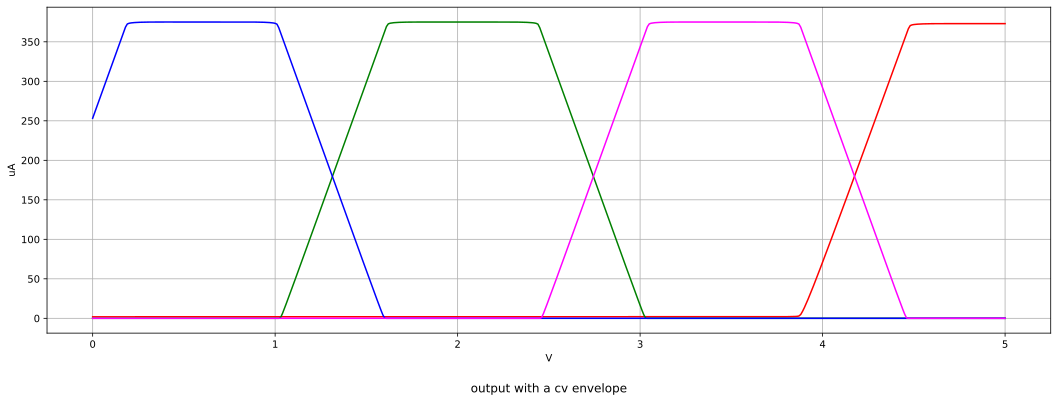

In [7]:
analysis_dc_scanner = simulator.dc(V7=slice(0, 5, .01))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq1_collector'] ), c='Red')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq2_collector'] ), c='Green')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq3_collector'] ), c='Blue')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq4_collector'] ), c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('V')
ax0.set_ylabel('uA')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()


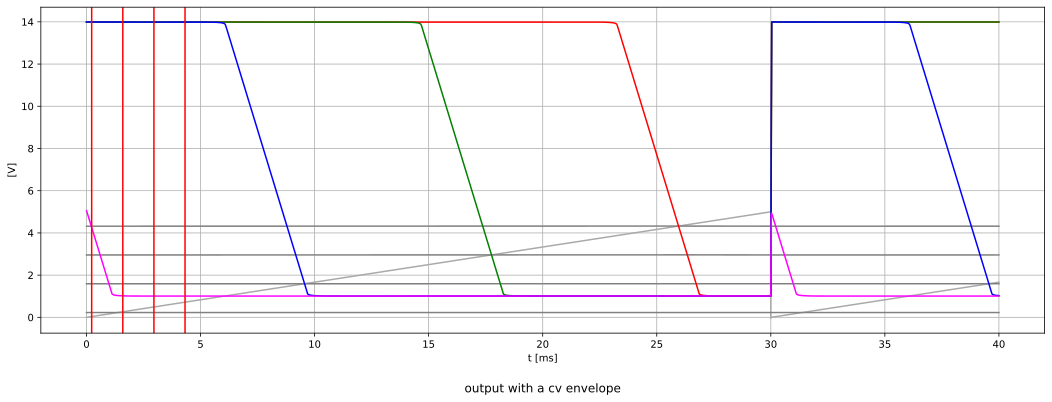

In [8]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_scanner['CV_S'].abscissa*1000, analysis_scanner['CV_S'], c='DarkGrey')  # envelope input (scaled)

#plot the voltages
ax0.plot(analysis_scanner['Net-_R1-Pad2_'].abscissa*1000, analysis_scanner['Net-_R1-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R2-Pad2_'].abscissa*1000, analysis_scanner['Net-_R2-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R3-Pad2_'].abscissa*1000, analysis_scanner['Net-_R3-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R4-Pad2_'].abscissa*1000, analysis_scanner['Net-_R4-Pad2_'], c='Grey')  # envelope input (scaled)

#plot output of the opamps
ax0.plot(analysis_scanner['Net-_Q1-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q1-Pad2_'], c='Red')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q4-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q4-Pad2_'], c='Green')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q2-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q2-Pad2_'], c='Blue')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q3-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q3-Pad2_'], c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

ax0.axvline(x=np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), color='red')
ax0.axvline(x=np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), color='red')
ax0.axvline(x=np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), color='red')
ax0.axvline(x=np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) ), color='red')

plt.show()


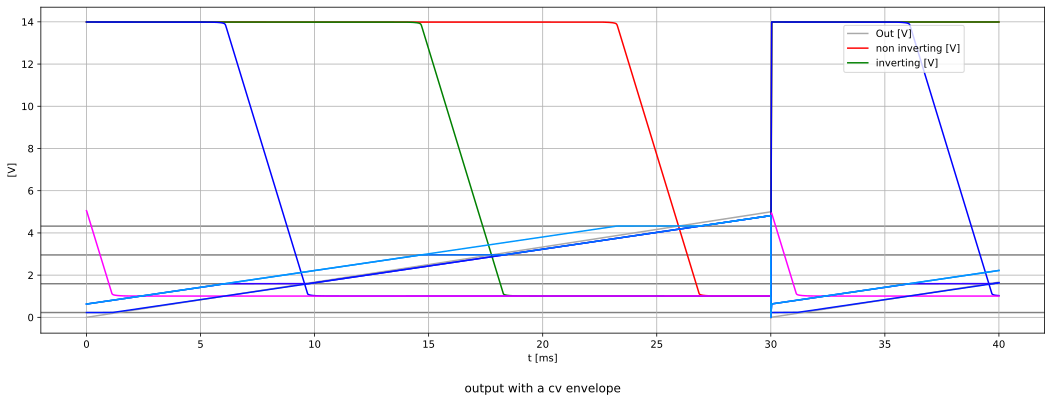

In [9]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_scanner['CV_S'].abscissa*1000, analysis_scanner['CV_S'], c='DarkGrey')  # envelope input (scaled)

#plot output of the opamps
ax0.plot(analysis_scanner['Net-_Q1-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q1-Pad2_'], c='Red')
ax0.plot(analysis_scanner['Net-_Q4-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q4-Pad2_'], c='Green')
ax0.plot(analysis_scanner['Net-_Q2-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q2-Pad2_'], c='Blue')
ax0.plot(analysis_scanner['Net-_Q3-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q3-Pad2_'], c='Magenta')

ax0.plot(analysis_scanner['Net-_R14-Pad2_'].abscissa*1000, analysis_scanner['Net-_R14-Pad2_'], c='#3701ff')
ax0.plot(analysis_scanner['Net-_R10-Pad1_'].abscissa*1000, analysis_scanner['Net-_R10-Pad1_'], c='#0118ff')
ax0.plot(analysis_scanner['Net-_R13-Pad2_'].abscissa*1000, analysis_scanner['Net-_R13-Pad2_'], c='#016dff')
ax0.plot(analysis_scanner['Net-_R12-Pad2_'].abscissa*1000, analysis_scanner['Net-_R12-Pad2_'], c='#0197ff')

ax0.legend(('Out [V]', 'non inverting [V]', 'inverting [V]'), loc=(.8,.8))

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

ax0.axhline(y=np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), color='Grey', zorder=-5)
ax0.axhline(y=np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), color='Grey', zorder=-5)
ax0.axhline(y=np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), color='Grey', zorder=-5)
ax0.axhline(y=np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) ), color='Grey', zorder=-5)

plt.show()


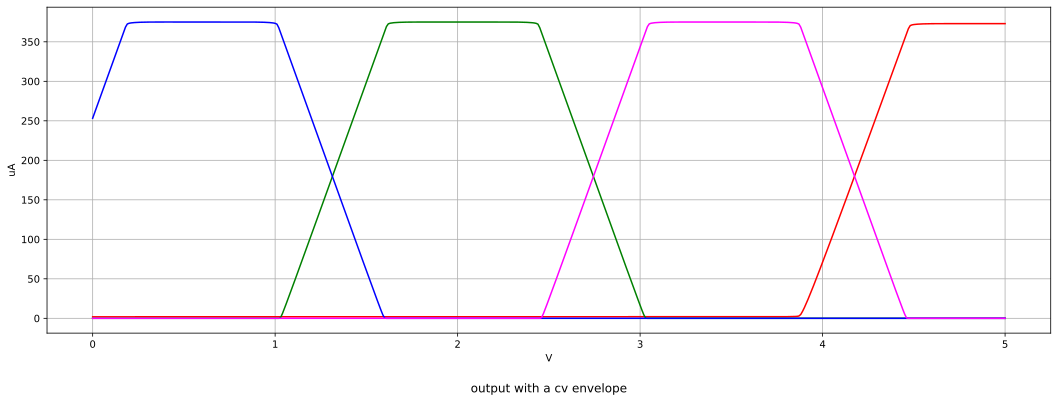

In [10]:
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq1_collector'] ), c='Red')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq2_collector'] ), c='Green')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq3_collector'] ), c='Blue')  # envelope input (scaled)
ax0.plot(analysis_dc_scanner['CV_IN'], u_uA(-analysis_dc_scanner['vq4_collector'] ), c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('V')
ax0.set_ylabel('uA')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

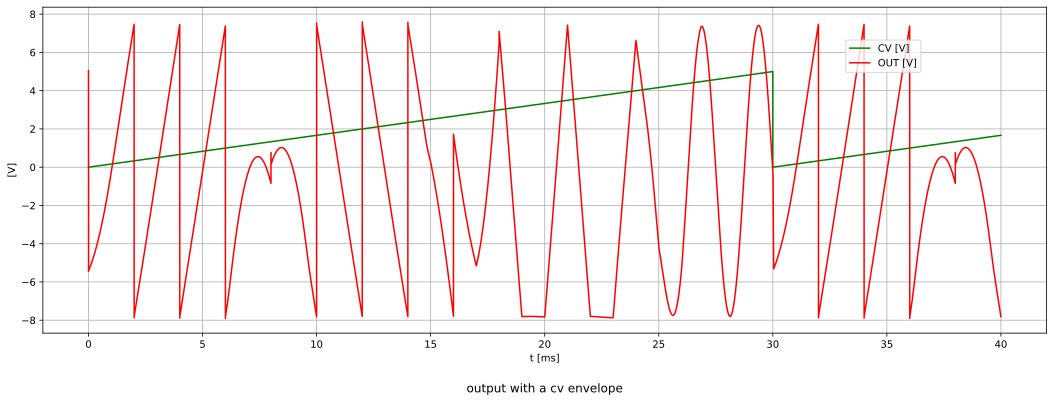

In [11]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_scanner['CV_S'].abscissa*1000, analysis_scanner['CV_S'], c='Green')  # envelope input (scaled)
#plot output
ax0.plot(analysis_scanner['OUT'].abscissa*1000, analysis_scanner['OUT'], c='Red')
ax0.legend(('CV [V]', 'OUT [V]'), loc=(.8,.8))

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [Muffwigler][1] thread with schematic from electrouwe

[1]: https://www.muffwiggler.com/forum/viewtopic.php?f=17&t=241171&start=25




In [12]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_input_audio (__main__.TestInputVoltages) ... ok
test_input_cv (__main__.TestInputVoltages) ... ok
test_voltage_divider (__main__.TestVoltageDivider) ... FAIL

FAIL: test_voltage_divider (__main__.TestVoltageDivider)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-6-e68bf9e37637>", line 4, in test_voltage_divider
    self.assertAlmostEqual(4.45@u_V, np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), places=1, msg='voltage divider R1')
AssertionError: UnitValue(4.45 V) != 4.320781469146966 within 1 places (0.12921853085303425 difference) : voltage divider R1

----------------------------------------------------------------------
Ran 3 tests in 0.013s

FAILED (failures=1)
